In [35]:
import os
import sys
from glob import glob

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL, PIL.Image
from torchvision.transforms.v2 import (
    ToPILImage,
    functional,
)

import shared.utils as su
from utils.video import read_frames_decord
from utils.model import transform_pixel_values

In [22]:
meta_dir = "/scratch/shared/beegfs/piyush/datasets/WebVid-CoVR"
video_dir = "/datasets/WebVid/videos"

df = pd.read_csv(f"{meta_dir}/webvid8m-covr_test-cleaned.csv")
df.shape

(2556, 9)

In [23]:
df['video1'] = df['video1'].apply(lambda x: f"{video_dir}/{x}")
df = df[df.video1.apply(os.path.exists)]
df.shape

(2556, 9)

In [24]:
df['video2'] = df['video2'].apply(lambda x: f"{video_dir}/{x}")
df = df[df.video2.apply(os.path.exists)]
df.shape

(2556, 9)

In [48]:
data_root = "/scratch/shared/beegfs/piyush/datasets/MSRVTT"
video_dir = f"{data_root}/videos/all/"

data = su.io.load_json(f"{data_root}/annotation/msrvtt_test_1k.json")
df = pd.DataFrame(data)

df['video_path'] = df.video.apply(lambda x: f"{video_dir}/{x}")
df['video_path'].apply(os.path.exists).mean()

text_col = "caption"
df.shape

df.iloc[0].to_dict()

{'video_id': 'video7020',
 'video': 'video7020.mp4',
 'caption': 'a woman creating a fondant baby and flower',
 'source': 'MSR-VTT',
 'category': 10,
 'url': 'https://www.youtube.com/watch?v=4KRMJNBjrEs',
 'start time': 221.77,
 'end time': 233.08,
 'id': 7020,
 'video_path': '/scratch/shared/beegfs/piyush/datasets/MSRVTT/videos/all//video7020.mp4'}

### Load models

In [37]:
from models.modeling_encoders import AutoEncoder

model_path = "/work/piyush/pretrained_checkpoints/Tarsier-7b/"
model = AutoEncoder.from_pretrained(
    model_path, dtype=torch.bfloat16, device_map="auto", attn_implementation="flash_attention_2",
)
su.misc.num_params(model.model)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading EncoderForTarsier from /work/piyush/pretrained_checkpoints/Tarsier-7b/
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
TarsierForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
You are attempting to use Flash Attention 2.

use_flash_attn is True and Flash Attention 2 is available on this GPU.
Using attn_implementation for TarsierForConditionalGeneration: flash_attention_2


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M


In [38]:
print(model.encode_text('sample').shape)
frames = read_frames_decord(video_path='../../TimeBound.v1/sample_data/folding_paper.mp4', num_frames=1)
print(model.encode_vision(frames.unsqueeze(0)).shape)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


torch.Size([1, 4096])
torch.Size([1, 4096])


In [41]:
frames.shape

torch.Size([1, 3, 240, 426])

In [39]:
def gather_text_features(model, texts: list):
    """Compute text embeddings for all unique text IDs."""
    texts_feat = {}
    for j, text in enumerate(
        su.log.tqdm_iterator(texts, desc='Computing text features')
    ):
        emb = model.encode_text(text)
        zt = emb.squeeze(0).cpu().float()
        texts_feat[text] = zt
        if j == 0:
            print("Text embedding:", zt.shape)
    return texts_feat


def gather_video_features(model, video_paths: list, num_frames=8):
    """Compute video embeddings for all unique video IDs."""
    video_feat = {}
    for j, video_path in enumerate(
        su.log.tqdm_iterator(video_paths, desc='Computing video features')
    ):
        try:
            frames = read_frames_decord(video_path=video_path, num_frames=num_frames)
        except:
            print(f"Failed reading {video_path}. Using dummy inputs.")
            frames = torch.zeros((num_frames, 3, 256, 256), dtype=int)
        emb = model.encode_vision(frames.unsqueeze(0))
        zv = emb.squeeze(0).cpu().float()
        video_feat[video_path] = zv
        if j == 0:
            print("Video embedding:", zv.shape)
    return video_feat

In [46]:
# PROMPT = "<image>\nEdit instruction: <sent>\n"\
#          "Imagine the given text edit instruction applied on the given image.\n"\
#          "Summarize the resulting image in one word:"

# PROMPT = "Source image: <video>\nEdit instruction: <sent>\n"\
#         "Look at the attached image carefully. The provided text is instruction to edit the image to a new sentence. "\
#         "Imagine this edit instruction being applied to the provided image.\n"\
#         "Summarize the resulting edited image in one word:"

PROMPT = "Video: <video>\nText:<sent>\nSummarise the combination of the given video-text in one word:"
PROMPT = f"USER: {PROMPT} ASSISTANT: "


def read_image(image_path):
    image = PIL.Image.open(image_path)
    image = torch.tensor(np.asarray(image)).unsqueeze(0)
    image = image.permute((0, 3, 1, 2))
    return image


def embed_image_text(encoder, image_path, edit_text, verbose=False):
    generate_kwargs = {
        "max_new_tokens": 1,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    # Prepare image
    pixel_values = read_image(image_path)
    pixel_values = transform_pixel_values(pixel_values)
    # print(pixel_values.shape)
    nframes = pixel_values.shape[1]
    to_image = ToPILImage()
    batched_frames = []
    for batch in pixel_values:
        frames = [to_image(v) for v in batch]
        batched_frames.append(frames)

    for frames in batched_frames:

        # Video
        input_prompt = PROMPT.replace("<video>", "<image>"*len(frames))

        # Text
        input_prompt = input_prompt.replace('<sent>', edit_text)

        if verbose:
            print(input_prompt)

        input_ids = encoder.processor.get_text_inputs(input_prompt)
        frames = encoder.processor.get_pixel_values(frames)
        inputs = {
            "input_ids": input_ids,
            "pixel_values": frames
        }
        inputs = {k:v.to(encoder.model.device) for k,v in inputs.items() if v is not None}
        outputs = encoder.model.generate(
            **inputs,
            **generate_kwargs,
        )
        zv = outputs.hidden_states[0][-1][:, -1, :]
        break # Safe to break since it is just one video

    if verbose:
        print(zv.shape)

    return zv.squeeze(0)


def embed_video_text(encoder, video_path, text, num_frames=8, verbose=False):
    generate_kwargs = {
        "max_new_tokens": 1,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    # Prepare image
    pixel_values = read_frames_decord(video_path=video_path, num_frames=num_frames)
    pixel_values = transform_pixel_values(pixel_values)
    # print(pixel_values.shape)
    nframes = pixel_values.shape[1]
    to_image = ToPILImage()
    batched_frames = []
    for batch in pixel_values:
        frames = [to_image(v) for v in batch]
        batched_frames.append(frames)

    for frames in batched_frames:

        # Video
        input_prompt = PROMPT.replace("<video>", "<image>"*len(frames))

        # Text
        input_prompt = input_prompt.replace('<sent>', text)

        if verbose:
            print(input_prompt)

        input_ids = encoder.processor.get_text_inputs(input_prompt)
        frames = encoder.processor.get_pixel_values(frames)
        inputs = {
            "input_ids": input_ids,
            "pixel_values": frames
        }
        inputs = {k:v.to(encoder.model.device) for k,v in inputs.items() if v is not None}
        outputs = encoder.model.generate(
            **inputs,
            **generate_kwargs,
        )
        zv = outputs.hidden_states[0][-1][:, -1, :]
        break # Safe to break since it is just one video

    if verbose:
        print(zv.shape)

    return zv.squeeze(0)


image_path = '../../TimeBound.v1/sample_data/folding_paper.png'
zv = embed_image_text(model, image_path, "Change background to blue.", verbose=True)

video_path = "../../TimeBound.v1/sample_data/folding_paper.mp4"
embed_video_text(model, text="This is a sample video", video_path=video_path, num_frames=2).shape

USER: Video: <image>
Text:Change background to blue.
Summarise the combination of the given video-text in one word: ASSISTANT: 
torch.Size([1, 4096])


torch.Size([4096])

In [47]:
def gather_video_text_features(model, video_paths: list, texts:list, num_frames=8):
    """Compute video text joint embeddings for all unique video IDs."""
    video_feat = {}
    for j, video_path in enumerate(
        su.log.tqdm_iterator(video_paths, desc='Computing video features')
    ):
        emb = embed_video_text(model, video_path, texts[j], num_frames=num_frames, verbose=False)
        zv = emb.squeeze(0).cpu().float()
        video_feat[video_path] = zv
        if j == 0:
            print("Video-text embedding:", zv.shape)
    return video_feat


gather_video_text_features(model, [video_path], ["Sample sentence"])

Computing video features:   0%|          | 0/1 [00:00<?, ?it/s]

Video-text embedding: torch.Size([4096])


{'../../TimeBound.v1/sample_data/folding_paper.mp4': tensor([ 3.4531,  0.6602,  2.1875,  ...,  3.7812, -0.3945, -2.3125])}

### Prepare data

In [49]:
texts_embeds = gather_text_features(model, df[text_col].unique())
len(texts_embeds)

Computing text features:   0%|          | 0/995 [00:00<?, ?it/s]

Text embedding: torch.Size([4096])


995

In [50]:
video_embeds = gather_video_features(model, df.video_path.unique(), num_frames=4)
len(video_embeds)

Computing video features:   0%|          | 0/1000 [00:00<?, ?it/s]

Video embedding: torch.Size([4096])


1000

In [51]:
video_text_embeds = gather_video_text_features(model, df.video_path.tolist(), df[text_col].tolist(), num_frames=4)
len(video_text_embeds)

Computing video features:   0%|          | 0/1000 [00:00<?, ?it/s]

Video-text embedding: torch.Size([4096])


1000

In [81]:
ZV = []
ZT = []
ZVT = []
for i in range(len(df)):
    row = df.iloc[i].to_dict()
    ZV.append(video_embeds[row['video_path']])
    ZT.append(texts_embeds[row[text_col]])
    ZVT.append(video_text_embeds[row['video_path']])
ZV = torch.stack(ZV)
ZT = torch.stack(ZT)
ZVT = torch.stack(ZVT)

norm = lambda x: torch.nn.functional.normalize(x, dim=-1)
ZV = norm(ZV)
ZT = norm(ZT)
ZVT = norm(ZVT)

ZV.shape, ZT.shape, ZVT.shape

(torch.Size([1000, 4096]), torch.Size([1000, 4096]), torch.Size([1000, 4096]))

In [90]:
Z = torch.cat([ZV, ZT, ZVT])
# Z = torch.cat([ZV, ZVT])
# Z = torch.cat([ZV, ZT])
z = su.visualize.reduce_dim(Z, method='pca')
z.shape

(3000, 2)

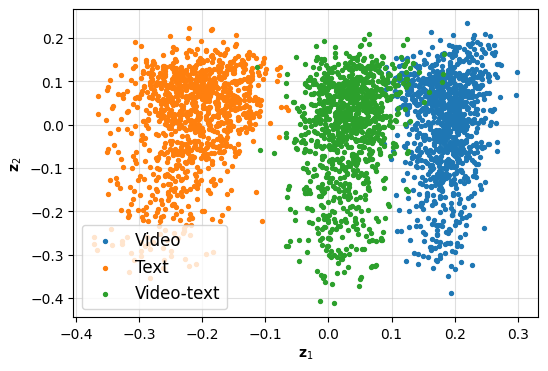

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.grid(alpha=0.4)

# Draw scatter points on top
n = len(ZV)
ax.scatter(z[:n, 0], z[:n, 1], s=8, label='Video', zorder=2)
ax.scatter(z[n:2*n, 0], z[n:2*n, 1], s=8, label='Text', zorder=2)
ax.scatter(z[2*n:, 0], z[2*n:, 1], s=8, label='Video-text', zorder=2)
# ax.scatter(z[n:2*n, 0], z[n:2*n, 1], s=8, label='Video-text', zorder=2)

ax.set_xlabel("$\\mathbf{z}_{1}$")
ax.set_ylabel("$\\mathbf{z}_{2}$")
ax.legend(fontsize=12)

plt.show()

In [85]:
(ZV.mean(dim=0) - ZT.mean(dim=0)).norm(), \
(ZV.mean(dim=0) - ZVT.mean(dim=0)).norm(), \
(ZT.mean(dim=0) - ZVT.mean(dim=0)).norm(),

(tensor(0.4032), tensor(0.2645), tensor(0.3110))

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D


def plot_tsne_3d(z, labels, figsize=(10, 8), cmap='tab10',
                 alpha=0.6, s=15, title='3D t-SNE Visualization',
                 elev=25, azim=45):
    z_np = z.detach().cpu().numpy() if hasattr(z, 'detach') else np.asarray(z)
    labels = np.asarray(labels)
    tsne = TSNE(n_components=3)
    embedding = tsne.fit_transform(z_np)

    fig = plt.figure(figsize=figsize, facecolor='white')
    ax = fig.add_subplot(111, projection='3d')

    unique_labels = np.unique(labels)
    cmap_obj = plt.cm.get_cmap(cmap, len(unique_labels))

    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax.scatter(embedding[mask, 0], embedding[mask, 1], embedding[mask, 2],
                   c=[cmap_obj(i)], label=str(label), s=s, alpha=alpha,
                   edgecolors='none', depthshade=True)

    ax.legend(title='Label', fontsize=9, title_fontsize=10,
              loc='upper left', markerscale=2, framealpha=0.8)

    ax.set_title(title, fontsize=14, weight='semibold', pad=12)
    ax.set_xlabel('t-SNE 1', fontsize=10, labelpad=8)
    ax.set_ylabel('t-SNE 2', fontsize=10, labelpad=8)
    ax.set_zlabel('t-SNE 3', fontsize=10, labelpad=8)
    ax.view_init(elev=elev, azim=azim)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('lightgrey')
    ax.yaxis.pane.set_edgecolor('lightgrey')
    ax.zaxis.pane.set_edgecolor('lightgrey')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()

    return fig, ax, embedding

In [77]:
labels = ['Video'] * n + ['Text'] * n + ['Video-text'] * n

Z = torch.cat([ZV, ZT, ZVT])

Z.shape, len(labels)

(torch.Size([3000, 4096]), 3000)

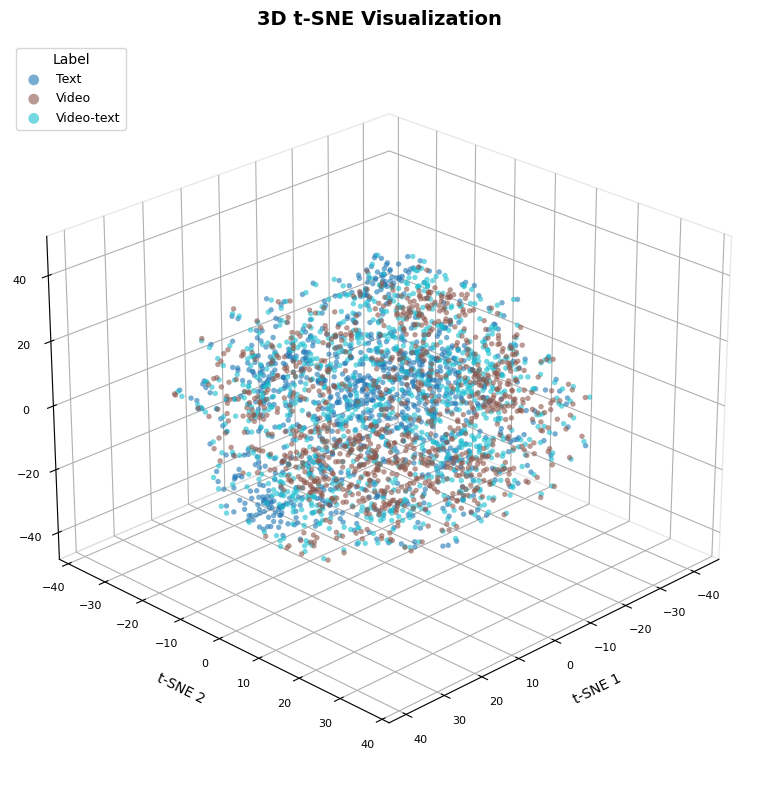

(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': '3D t-SNE Visualization'}, xlabel='t-SNE 1', ylabel='t-SNE 2', zlabel='t-SNE 3'>,
 array([[  9.680811 ,  10.685832 ,  25.941423 ],
        [  4.849981 ,  -0.1002208, -35.518497 ],
        [ 18.2709   ,   7.162594 ,  24.17224  ],
        ...,
        [ 24.946238 ,  -5.5194545,  -5.4998326],
        [  5.0500684,  11.310161 ,   1.6487257],
        [-11.718828 ,  14.4588585,  14.050939 ]], dtype=float32))

In [78]:
plot_tsne_3d(Z, labels)

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


def plot_pca_3d(z, labels, figsize=(10, 8), cmap='tab10',
                alpha=0.6, s=15, title='3D PCA Visualization',
                elev=25, azim=45):
    z_np = z.detach().cpu().numpy() if hasattr(z, 'detach') else np.asarray(z)
    labels = np.asarray(labels)

    pca = PCA(n_components=3)
    embedding = pca.fit_transform(z_np)

    fig = plt.figure(figsize=figsize, facecolor='white')
    ax = fig.add_subplot(111, projection='3d')

    unique_labels = np.unique(labels)
    cmap_obj = plt.cm.get_cmap(cmap, len(unique_labels))

    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax.scatter(embedding[mask, 0], embedding[mask, 1], embedding[mask, 2],
                   c=[cmap_obj(i)], label=str(label), s=s, alpha=alpha,
                   edgecolors='none', depthshade=True)

    ax.legend(title='Label', fontsize=9, title_fontsize=10,
              loc='upper left', markerscale=2, framealpha=0.8)

    var = pca.explained_variance_ratio_ * 100
    ax.set_title(title, fontsize=14, weight='semibold', pad=12)
    ax.set_xlabel(f'PC1 ({var[0]:.1f}%)', fontsize=10, labelpad=8)
    ax.set_ylabel(f'PC2 ({var[1]:.1f}%)', fontsize=10, labelpad=8)
    ax.set_zlabel(f'PC3 ({var[2]:.1f}%)', fontsize=10, labelpad=8)
    ax.view_init(elev=elev, azim=azim)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('lightgrey')
    ax.yaxis.pane.set_edgecolor('lightgrey')
    ax.zaxis.pane.set_edgecolor('lightgrey')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()

    return fig, ax, embedding

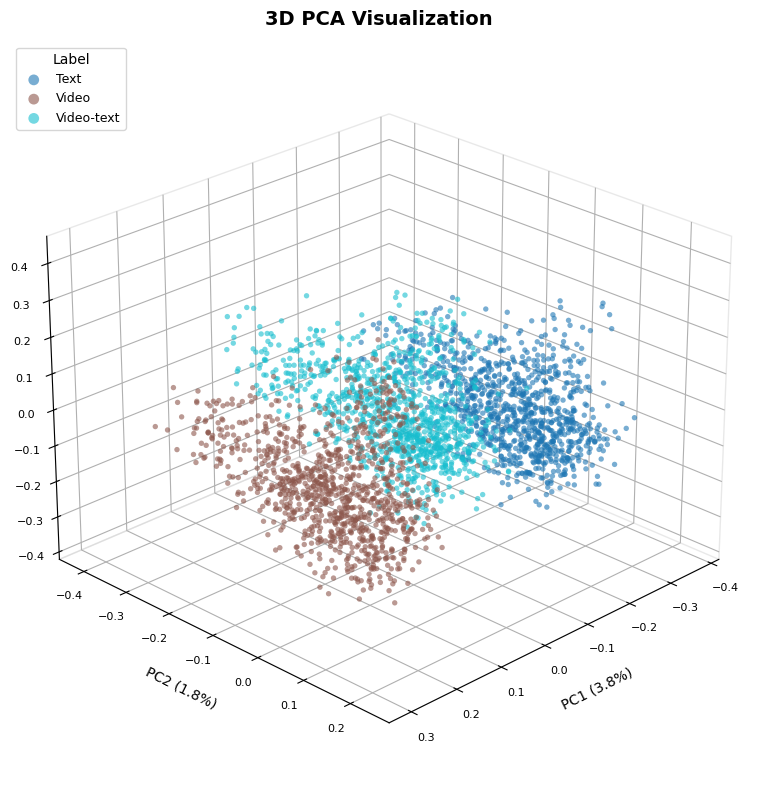

(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': '3D PCA Visualization'}, xlabel='PC1 (3.8%)', ylabel='PC2 (1.8%)', zlabel='PC3 (1.7%)'>,
 array([[ 0.17484209,  0.10550654,  0.16051848],
        [ 0.11934547,  0.11707022, -0.17971513],
        [ 0.1800265 ,  0.07433924,  0.1367383 ],
        ...,
        [ 0.01005366,  0.06670034,  0.00458318],
        [-0.01118829, -0.18579178,  0.10118384],
        [-0.021957  ,  0.00086457,  0.05402083]], dtype=float32))

In [93]:
plot_pca_3d(Z, labels)